### [Random effects]

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, DataFrames, CSV
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data from file:

In [2]:
m = CSV.read("covtype.data", header=false)
m = Float64.(convert(Array,m));

#### Pre-processing (normalize data, get it into the proper shape, etc):

In [3]:
dat = zeros(size(m[:,1:10]))
mu, sd = vec(mean(m[:,1:10],1)), vec(std(m[:,1:10],1))

@showprogress for i in 1:size(m,1) 
    dat[i,:] = (m[i,1:10]-mu)./sd
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04:34


In [4]:
group_counts = [sum(m[:,end].==i) for i in 1:7]
K = length(group_counts)
Nobs = sum(group_counts)

581012

In [5]:
X_cov = dat[sortperm(m[:,end]),:]'
y = m[sortperm(m[:,end]),11]
d_cov = size(X_cov,1)

10

In [6]:
d = 1+K+d_cov
X = spzeros(Nobs,d)
X[:,1] = 1.
X[:,K+2:end] = X_cov';
for (k,count) in enumerate(group_counts) 
    X[sum(group_counts[1:k-1])+(1:count),k+1] = 1.
end
X = X';

In [7]:
size(X)

(18, 581012)

In [8]:
Nobs*maximum(abs.(X),2)./sum(abs.(X),2)

18×1 Array{Float64,2}:
   1.0    
   2.74269
   2.05086
  16.2503 
 211.508  
  61.2043 
  33.4549 
  28.3282 
   5.07292
   2.08541
   8.76177
   6.73897
  13.0254 
   3.70299
  10.2622 
  14.6806 
   4.76492
   5.19252

#### Define model:

In [31]:
σ02 = 1
prior = MM_prior(d_cov, K, 1);
# prior = gaussian_prior_nh(d, σ02);
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);
root = rand(d);

#### Define minibatch sampler:

In [59]:
# Stratified sub-sampling without CV and without weights 

cmbsamplers = Array{mbsampler}(d)
cmbsamplers[1] = umbsampler(0, Nobs, K)

for (k,count) in enumerate(group_counts)
    cmbsamplers[k+1] = umbsampler(sum(group_counts[1:k-1]), count, 1000, 1/1000, 1/Nobs)
end

weights = sparse(abs.(X))
for dim in (1+K+1):(1+K+d_cov) 
    weights[dim,:] /= sum(weights[dim,:])
end
ll_pd_root_list = [partial_derivative_vec(my_model.ll, root, dim, 1:Nobs) for dim in 1:d];
N_cluster = K
@showprogress for dim in (1+K+1):(1+K+d_cov)
    csamplers = Array{mbsampler}(N_cluster)
    clusters = []
    for (k,count) in enumerate(group_counts)  
        push!(clusters, Array(sum(group_counts[1:k-1])+(1:count)))
    end
    
    scp = ones(N_cluster)            # this is mb size per cluster
    for (ci, c) in enumerate(clusters)
        if dim > 1+K 
#             csamplers[ci] = wumbsampler(size(c,1), scp[ci], weights[dim,c])
            csamplers[ci] = umbsampler(0, size(c,1), mb_size/10)
        end
    end
    cmbsamplers[dim] = spcmbsampler(csamplers, clusters, weights[dim,:])
   
end
gs_list = mbsampler_list(d,cmbsamplers);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


#### Define output scheduler etc:

In [60]:
A_xi = eye(d)
A_hyp = eye(hyperparam_size(prior))

opf = projopf(A_xi, A_hyp, 10^3)
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [61]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e3)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [62]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10 percent attempts in 0.91 min; zz bounces = 538, hyp bounces = 9, total time of process = 0.011 
20 percent attempts in 1.90 min; zz bounces = 928, hyp bounces = 20, total time of process = 0.022 
30 percent attempts in 2.90 min; zz bounces = 1216, hyp bounces = 32, total time of process = 0.033 
40 percent attempts in 3.88 min; zz bounces = 1386, hyp bounces = 50, total time of process = 0.044 
50 percent attempts in 4.88 min; zz bounces = 1621, hyp bounces = 61, total time of process = 0.055 
60 percent attempts in 5.88 min; zz bounces = 1864, hyp bounces = 75, total time of process = 0.066 
70 percent attempts in 6.89 min; zz bounces = 2158, hyp bounces = 85, total time of process = 0.077 
80 percent attempts in 7.88 min; zz bounces = 2448, hyp bounces = 97, total time of process = 0.088 
90 percent attempts in 8.88 min; zz bounces = 2748, hyp bounces = 115, total time of process = 0.099 
100 percent attempts in 9.88 min; zz bounces = 3108, hyp bounces = 125, total time of process

#### Plot speeds:

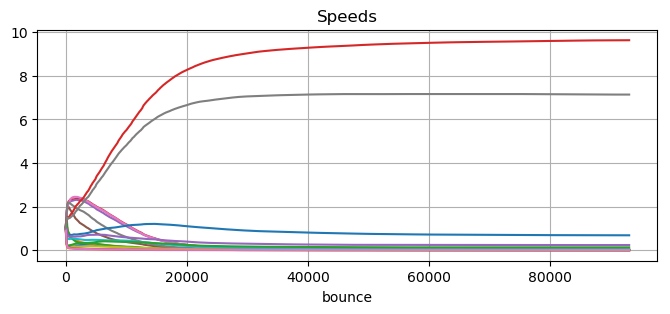

In [33]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

#### Extract samples:

In [34]:
discard = 0
n_samples = 10^3
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear")[:,1:end-1];

#### Plot ACFs:

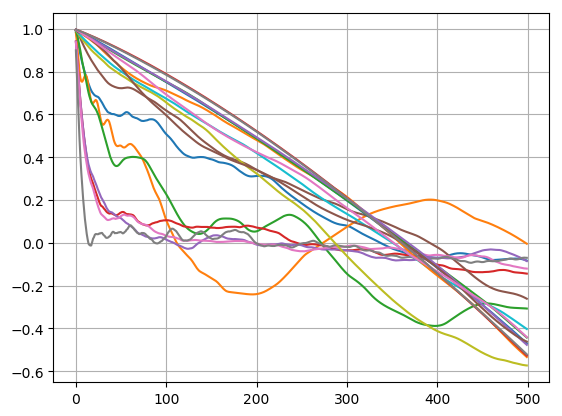

In [35]:
for i in 1:size(xi_samples,1) 
    plot(acf(xi_samples[i,:], 500))
end
grid(true)